In [84]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random


### Get Data

In [110]:
df_train = pd.read_csv('audio_data5_train.csv')
bird_df = df_train[df_train["breed"].notna()]
# Extract MFCC feature columns
X_train = bird_df.iloc[:,5:].values

# Convert labels to numeric numbers
y_train = bird_df["breed"].map({"wood_warbler": 0,"barn_swallow": 1,"meadow_pipit": 2,"common_wood_pigeon": 3,"marsh_warbler": 4,"common_house_martin": 5,"african_pied_wagtail": 6,"common_chiffchaff": 7,"common_moorhen": 8,"northern_lapwing": 9,"european_robin": 10,"dunnock": 11,"european_greenfinch": 12,"goldcrest": 13,"corn_bunting": 14,"great_spotted_woodpecker": 15,"red-throated_loon": 16,"european_green_woodpecker": 17,"eurasian_wryneck": 18,"eurasian_collared_dove": 19,"redwing": 20,"willow_tit": 21,"dunlin": 22,"common_redpoll": 23,"tawny_owl": 24,"eurasian_wren": 25,"eurasian_treecreeper": 26,"eurasian_skylark": 27,"common_redshank": 28,"eurasian_coot": 29,"grey_plover": 30,"black_woodpecker": 31,"grey_partridge": 32,"stock_dove": 33,"nan": 34,"western_jackdaw": 35,"rook": 36,"marsh_tit": 37,"yellowhammer": 38,"great_tit": 39,"european_nightjar": 40,"european_bee-eater": 41,"long-tailed_tit": 42,"european_golden_plover": 43,"common_redstart": 44,"garden_warbler": 45,"common_linnet": 46,"tree_pipit": 47,"common_swift": 48,"common_nightingale": 49,"river_warbler": 50,"willow_ptarmigan": 51,"european_goldfinch": 52,"european_herring_gull": 53,"common_pheasant": 54,"song_thrush": 55,"common_blackbird": 56,"western_yellow_wagtail": 57,"eurasian_tree_sparrow": 58,"house_sparrow": 59,"canada_goose": 60,"carrion_crow": 61,"common_chaffinch": 62,"eurasian_bullfinch": 63,"european_turtle_dove": 64,"red_crossbill": 65,"northern_raven": 66,"common_cuckoo": 67,"spotted_flycatcher": 68,"lesser_whitethroat": 69,"eurasian_oystercatcher": 70,"sedge_warbler": 71,"eurasian_magpie": 72,"european_honey_buzzard": 73,"rock_dove": 74,"eurasian_blackcap": 75,"common_reed_bunting": 76,"black-headed_gull": 77,"coal_tit": 78,"eurasian_reed_warbler": 79,"eurasian_golden_oriole": 80,"common_snipe": 81,"willow_warbler": 82,"eurasian_nuthatch": 83,"eurasian_jay": 84,"common_whitethroat": 85,"wood_sandpiper": 86,"eurasian_blue_tit": 87,"common_starling": 88}).values

df_test = pd.read_csv('audio_data5_test.csv')
bird_test_df = df_test[df_test["breed"].notna()]
# Extract MFCC feature columns
X_test = bird_test_df.iloc[:,5:].values

# Convert labels to numeric numbers
y_test = bird_test_df["breed"].map({"wood_warbler": 0,"barn_swallow": 1,"meadow_pipit": 2,"common_wood_pigeon": 3,"marsh_warbler": 4,"common_house_martin": 5,"african_pied_wagtail": 6,"common_chiffchaff": 7,"common_moorhen": 8,"northern_lapwing": 9,"european_robin": 10,"dunnock": 11,"european_greenfinch": 12,"goldcrest": 13,"corn_bunting": 14,"great_spotted_woodpecker": 15,"red-throated_loon": 16,"european_green_woodpecker": 17,"eurasian_wryneck": 18,"eurasian_collared_dove": 19,"redwing": 20,"willow_tit": 21,"dunlin": 22,"common_redpoll": 23,"tawny_owl": 24,"eurasian_wren": 25,"eurasian_treecreeper": 26,"eurasian_skylark": 27,"common_redshank": 28,"eurasian_coot": 29,"grey_plover": 30,"black_woodpecker": 31,"grey_partridge": 32,"stock_dove": 33,"nan": 34,"western_jackdaw": 35,"rook": 36,"marsh_tit": 37,"yellowhammer": 38,"great_tit": 39,"european_nightjar": 40,"european_bee-eater": 41,"long-tailed_tit": 42,"european_golden_plover": 43,"common_redstart": 44,"garden_warbler": 45,"common_linnet": 46,"tree_pipit": 47,"common_swift": 48,"common_nightingale": 49,"river_warbler": 50,"willow_ptarmigan": 51,"european_goldfinch": 52,"european_herring_gull": 53,"common_pheasant": 54,"song_thrush": 55,"common_blackbird": 56,"western_yellow_wagtail": 57,"eurasian_tree_sparrow": 58,"house_sparrow": 59,"canada_goose": 60,"carrion_crow": 61,"common_chaffinch": 62,"eurasian_bullfinch": 63,"european_turtle_dove": 64,"red_crossbill": 65,"northern_raven": 66,"common_cuckoo": 67,"spotted_flycatcher": 68,"lesser_whitethroat": 69,"eurasian_oystercatcher": 70,"sedge_warbler": 71,"eurasian_magpie": 72,"european_honey_buzzard": 73,"rock_dove": 74,"eurasian_blackcap": 75,"common_reed_bunting": 76,"black-headed_gull": 77,"coal_tit": 78,"eurasian_reed_warbler": 79,"eurasian_golden_oriole": 80,"common_snipe": 81,"willow_warbler": 82,"eurasian_nuthatch": 83,"eurasian_jay": 84,"common_whitethroat": 85,"wood_sandpiper": 86,"eurasian_blue_tit": 87,"common_starling": 88}).values

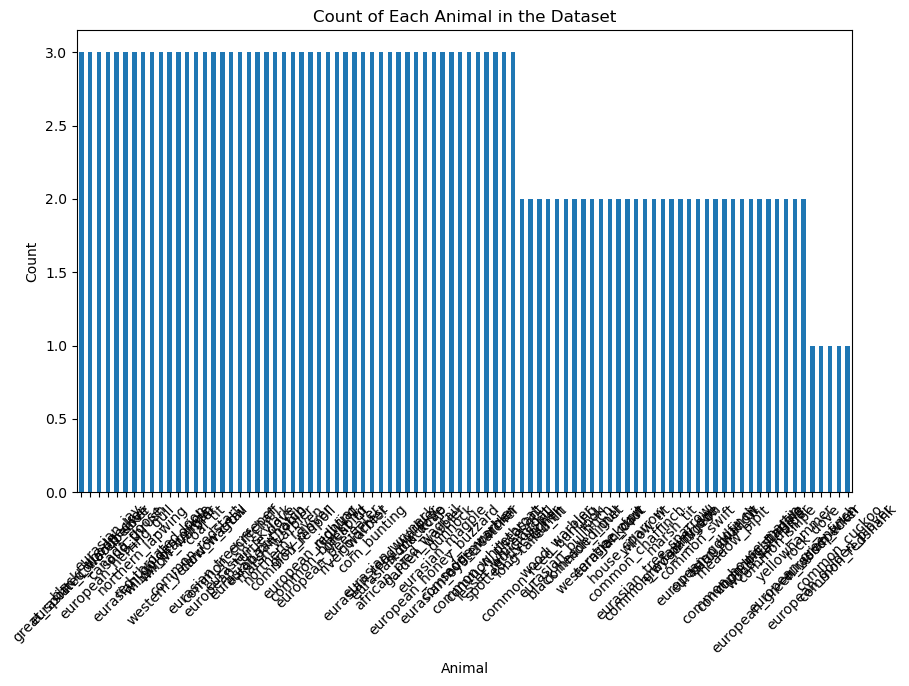

In [111]:
label_counts = bird_df['breed'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Animal')
plt.ylabel('Count')
plt.title('Count of Each Animal in the Dataset')
plt.xticks(rotation=45)
plt.show()

In [112]:
def reshape_mfcc(mfcc_vector, height=37, width=36):
    padded = np.pad(mfcc_vector, (0, height * width - len(mfcc_vector)), mode='constant')
    return padded.reshape(height, width)

# Reshape all MFCC data
X_train = np.array([reshape_mfcc(x) for x in X_train])
# X_val = np.array([reshape_mfcc(x) for x in X_val])
X_test = np.array([reshape_mfcc(x) for x in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [113]:
# Define Dataset class
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = MFCCDataset(X_train_tensor, y_train_tensor)
# val_dataset = MFCCDataset(X_val_tensor, y_val_tensor)
test_dataset = MFCCDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Create Model

In [131]:
class CNN_Audio2(nn.Module):
    def __init__(self, input_shape=(1, 36, 36), num_conv_layers=2, conv1_out=16, conv2_out=32, conv3_out=64, fc1_out=128, dropout_rate=0.5):
        super(CNN_Audio2, self).__init__()
        
        self.num_conv_layers = num_conv_layers
        
        # Create a list of convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = 1  # Input is grayscale image (1 channel)

        # First convolution layer
        self.conv_layers.append(nn.Conv2d(in_channels, conv1_out, kernel_size=3, stride=1, padding=1))
        in_channels = conv1_out
        
        # Second convolution layer
        self.conv_layers.append(nn.Conv2d(in_channels, conv2_out, kernel_size=3, stride=1, padding=1))
        in_channels = conv2_out
        
        # Additional convolution layers based on num_conv_layers
        if num_conv_layers > 2:
            self.conv_layers.append(nn.Conv2d(in_channels, conv3_out, kernel_size=3, stride=1, padding=1))
            in_channels = conv3_out
        
        # Add pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Calculate flattened size after convolution and pooling layers
        self.flattened_size = self._get_flattened_size(input_shape)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, fc1_out)
        self.fc2 = nn.Linear(fc1_out, 89)  # Assuming 89 output classes (adjust as necessary)

    def _get_flattened_size(self, input_shape):
        """Pass dummy data through conv and pooling layers to get final feature map size."""
        x = torch.zeros(1, *input_shape)
        for conv_layer in self.conv_layers:
            x = self.pool(torch.relu(conv_layer(x)))
        return x.numel()  # Total elements in the tensor

    def forward(self, x):
        # Apply convolution and pooling layers
        for conv_layer in self.conv_layers:
            x = self.pool(torch.relu(conv_layer(x)))

        # Flatten the tensor before passing to fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Random Search

In [134]:
param_grid = {
    "num_conv_layers": [2, 3, 4],  # Number of convolutional layers
    "conv1_out": [16, 32, 64],  # Number of filters for the first convolution layer
    "conv2_out": [32, 64, 128],  # Number of filters for the second convolution layer
    "conv3_out": [64, 128],  # If more than 2 layers, specify the 3rd layer filter size
    "pool_type": ["max", "avg"],  # Pooling types
    "dropout": [0.2, 0.3, 0.5],  # Dropout rates
    "fc_units": [128, 256, 512],  # Fully connected layer units
    "lr": [0.001, 0.0005, 0.0001],  # Learning rates
    "batch_size": [32, 64, 128],  # Batch sizes
    "optimizer": ["Adam", "SGD"],  # Optimizers
}


In [137]:
def train_and_evaluate(params):
    # Unpack parameters
    num_conv_layers = params["num_conv_layers"]
    conv1_out = params["conv1_out"]
    conv2_out = params["conv2_out"]
    conv3_out = params["conv3_out"]
    fc1_out = params["fc_units"]
    lr = params["lr"]
    batch_size = params["batch_size"]
    optimizer_name = params["optimizer"]
    dropout_rate = params["dropout"]

    # Initialize model
    model = CNN_Audio2(
        num_conv_layers=num_conv_layers, 
        conv1_out=conv1_out, 
        conv2_out=conv2_out, 
        conv3_out=conv3_out,  # Ensure the 3rd conv layer is passed if num_conv_layers > 2
        fc1_out=fc1_out, 
        dropout_rate=dropout_rate
    )
    criterion = nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    num_epochs = 10
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)  # No squeeze
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))  # Track training loss

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)  # No squeeze
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_losses.append(val_loss / len(test_loader))  # Track validation loss
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return val_losses[-1]  # Return final validation loss


In [138]:
# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

num_searches = 10  # Number of random trials
best_params = None
best_loss = float("inf")

for _ in range(num_searches):
    params = {key: random.choice(values) for key, values in param_grid.items()}
    
    try:
        val_loss = train_and_evaluate(params)
        print(f"Params: {params}, Validation Loss: {val_loss:.4f}")

        # Track the best parameters
        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
    except Exception as e:
        print(f"Error with params {params}: {e}")

print("\nBest Parameters:", best_params)
print("Best Validation Loss:", best_loss)


Epoch 1/10, Train Loss: 4.4909, Val Loss: 4.4823
Epoch 2/10, Train Loss: 4.4812, Val Loss: 4.4836
Epoch 3/10, Train Loss: 4.4776, Val Loss: 4.4889
Epoch 4/10, Train Loss: 4.4699, Val Loss: 4.4910
Epoch 5/10, Train Loss: 4.4573, Val Loss: 4.4910
Epoch 6/10, Train Loss: 4.4501, Val Loss: 4.4939
Epoch 7/10, Train Loss: 4.4381, Val Loss: 4.4997
Epoch 8/10, Train Loss: 4.4275, Val Loss: 4.5030
Epoch 9/10, Train Loss: 4.4140, Val Loss: 4.5078
Epoch 10/10, Train Loss: 4.3923, Val Loss: 4.5094
Params: {'num_conv_layers': 4, 'conv1_out': 16, 'conv2_out': 32, 'conv3_out': 128, 'pool_type': 'max', 'dropout': 0.2, 'fc_units': 128, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'Adam'}, Validation Loss: 4.5094
Epoch 1/10, Train Loss: 4.4913, Val Loss: 4.4986
Epoch 2/10, Train Loss: 4.4842, Val Loss: 4.5034
Epoch 3/10, Train Loss: 4.4771, Val Loss: 4.5083
Epoch 4/10, Train Loss: 4.4704, Val Loss: 4.5127
Epoch 5/10, Train Loss: 4.4664, Val Loss: 4.5187
Epoch 6/10, Train Loss: 4.4588, Val Loss: 4.5253
E

### Train Model

In [ ]:
# model = CNN_Audio2()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 50
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs).squeeze(1)  # Ensure outputs are of shape [batch_size]
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     train_losses.append(running_loss / len(train_loader))

#     # Validation loss
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs).squeeze(1)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#     val_losses.append(val_loss / len(test_loader))

#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

# print("Training complete!")


Epoch 1/50, Training Loss: 4.549184662955148, Validation Loss: 4.558371067047119
Epoch 2/50, Training Loss: 4.4084290095738, Validation Loss: 4.609732151031494
Epoch 3/50, Training Loss: 4.2393084934779575, Validation Loss: 4.897281885147095
Epoch 4/50, Training Loss: 3.998016834259033, Validation Loss: 5.12285852432251
Epoch 5/50, Training Loss: 3.6701267787388394, Validation Loss: 5.41370964050293
Epoch 6/50, Training Loss: 3.312278849737985, Validation Loss: 5.5393147468566895
Epoch 7/50, Training Loss: 2.8898775577545166, Validation Loss: 5.955665349960327
Epoch 8/50, Training Loss: 2.4988960197993686, Validation Loss: 6.323317050933838
Epoch 9/50, Training Loss: 2.158988050052098, Validation Loss: 6.519229173660278
Epoch 10/50, Training Loss: 1.8081592661993844, Validation Loss: 7.271558046340942
Epoch 11/50, Training Loss: 1.4784444229943412, Validation Loss: 7.820335865020752
Epoch 12/50, Training Loss: 1.190678596496582, Validation Loss: 8.421488046646118
Epoch 13/50, Training 

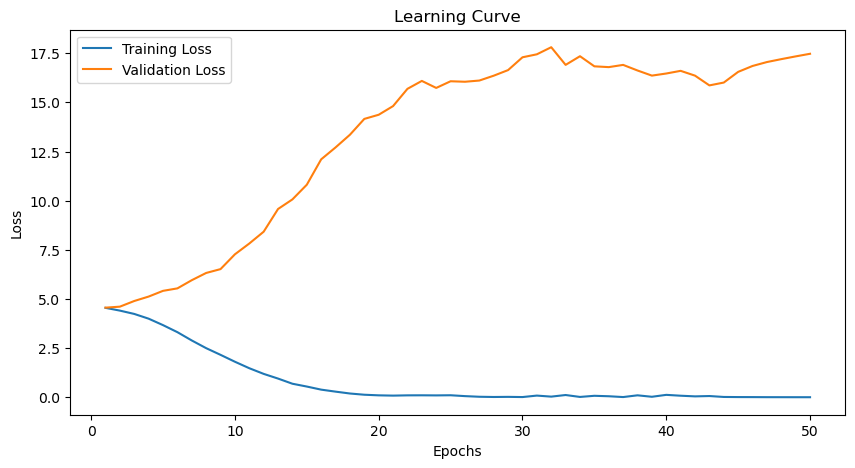

In [80]:
# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [81]:
# # Evaluate the model on the test set
# model.eval()
# all_preds, all_labels = [], []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())
        
# # Compute the confusion matrix
# cm = confusion_matrix(all_labels, all_preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["frog","donkey","cat","monkey","baby sheep","bird","lion","cow","dog","chicken"])

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))  # Increase the figure size
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')

# # Rotate the x-axis labels
# plt.xticks(rotation=45)

# plt.show()

In [139]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.046511627906976744


In [140]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 1.0
